In [51]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

In [52]:
## read in data
df = pd.read_csv("./data.csv",header=0,low_memory=False)
## see columns
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [53]:
# Select the ones you want
ids = ["FIRE_YEAR","DISCOVERY_DATE","DISCOVERY_DOY","DISCOVERY_TIME",
        "CONT_DATE","CONT_DOY","CONT_TIME","LATITUDE","LONGITUDE","STATE","COUNTY",
       "FIRE_SIZE","FIRE_SIZE_CLASS","STAT_CAUSE_DESCR"]
df1 = df[ids]

In [54]:
epoch = pd.to_datetime(0, unit='s').to_julian_date()
df1['DISCOVERY_DATE'] = pd.to_datetime(df1['DISCOVERY_DATE'] - epoch, unit='D')
df1['CONT_DATE'] = pd.to_datetime(df1['CONT_DATE'] - epoch, unit='D')
print(df1.head())
print(df1.tail())

   FIRE_YEAR DISCOVERY_DATE  DISCOVERY_DOY  DISCOVERY_TIME  CONT_DATE  \
0       2005     2005-02-02             33          1300.0 2005-02-02   
1       2004     2004-05-12            133           845.0 2004-05-12   
2       2004     2004-05-31            152          1921.0 2004-05-31   
3       2004     2004-06-28            180          1600.0 2004-07-03   
4       2004     2004-06-28            180          1600.0 2004-07-03   

   CONT_DOY  CONT_TIME   LATITUDE   LONGITUDE STATE COUNTY  FIRE_SIZE  \
0      33.0     1730.0  40.036944 -121.005833    CA     63       0.10   
1     133.0     1530.0  38.933056 -120.404444    CA     61       0.25   
2     152.0     2024.0  38.984167 -120.735556    CA     17       0.10   
3     185.0     1400.0  38.559167 -119.913333    CA      3       0.10   
4     185.0     1200.0  38.559167 -119.933056    CA      3       0.10   

  FIRE_SIZE_CLASS STAT_CAUSE_DESCR  
0               A    Miscellaneous  
1               A        Lightning  
2          

In [6]:
## remove, take 1: rows without fire cause
df3 = df1.dropna(subset=['STAT_CAUSE_DESCR'], inplace=False)
subset = (df3.STAT_CAUSE_DESCR != "Missing/Undefined") & (df3.STAT_CAUSE_DESCR != "Miscellaneous")
df3 = df3[subset]


In [7]:
## remove, take 2: rows with incomplete information
# test how many na vals are in each column
print("total observations: {}".format(df3.shape[0]))
print("missing values by column:")
df3.isnull().sum()
# remove incomplete rows
df4 = df3.dropna(how = 'any')
# df4.shape

total observations: 1389937
missing values by column:


In [8]:
## check distribution of dependent variable after reduction
df4.STAT_CAUSE_DESCR.value_counts()

Debris Burning    139361
Lightning         115211
Arson              92694
Equipment Use      33428
Campfire           28425
Smoking            15065
Children           12246
Railroad            5808
Powerline           5604
Fireworks           2669
Structure           1386
Name: STAT_CAUSE_DESCR, dtype: int64

In [56]:
print(df4.head())
print()

print(df4.tail())

   FIRE_YEAR DISCOVERY_DATE  DISCOVERY_DOY  DISCOVERY_TIME  CONT_DATE  \
1       2004     2004-05-12            133           845.0 2004-05-12   
2       2004     2004-05-31            152          1921.0 2004-05-31   
3       2004     2004-06-28            180          1600.0 2004-07-03   
4       2004     2004-06-28            180          1600.0 2004-07-03   
5       2004     2004-06-30            182          1800.0 2004-07-01   

   CONT_DOY  CONT_TIME   LATITUDE   LONGITUDE STATE COUNTY  FIRE_SIZE  \
1     133.0     1530.0  38.933056 -120.404444    CA     61       0.25   
2     152.0     2024.0  38.984167 -120.735556    CA     17       0.10   
3     185.0     1400.0  38.559167 -119.913333    CA      3       0.10   
4     185.0     1200.0  38.559167 -119.933056    CA      3       0.10   
5     183.0     1600.0  38.635278 -120.103611    CA      5       0.10   

  FIRE_SIZE_CLASS STAT_CAUSE_DESCR  
1               A        Lightning  
2               A   Debris Burning  
3          

In [40]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, preprocessing, tree, ensemble
le = preprocessing.LabelEncoder()

n_neighbors = 5

# import some data to play with
# iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
test_ids = ["FIRE_YEAR","DISCOVERY_DOY","DISCOVERY_TIME",
        "CONT_DOY","CONT_TIME","LATITUDE","LONGITUDE","STATE",
       "FIRE_SIZE","FIRE_SIZE_CLASS"]
# ,"DISCOVERY_DATE", "CONT_DATE",

df5 = df4.copy()
df5['FIRE_SIZE_CLASS'] =le.fit_transform(df5['FIRE_SIZE_CLASS'])
df5['STATE'] =le.fit_transform(df5['STATE'])

X = df5[test_ids]
y = df5[['STAT_CAUSE_DESCR']]

# filter data into train and test sets
msk = np.random.rand(len(df4)) < 0.8
train_x = X[msk]
test_x = X[~msk]
train_y = y[msk]
test_y = y[~msk]

# define classifiers
knn_clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
knn_dist_clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
dt_clf = tree.DecisionTreeClassifier()
rf_clf = ensemble.RandomForestClassifier()

# fit to training data
knn_clf.fit(train_x, train_y)
knn_dist_clf.fit(train_x, train_y)
dt_clf.fit(train_x, train_y)
rf_clf.fit(train_x, train_y)

# predict for test data
knn_predictions = knn_clf.predict(test_x)
knn_dist_predictions = knn_dist_clf.predict(test_x)
dt_predictions = dt_clf.predict(test_x)
rf_predictions = rf_clf.predict(test_x)

# accuracy
print(knn_clf.score(test_x, test_y))
print(knn_dist_clf.score(test_x, test_y))
print(dt_clf.score(test_x, test_y))
print(rf_clf.score(test_x, test_y))



0.5235192601278846
0.5293271677323717
0.5406885412748633
0.6236697125915437


In [31]:
labs = df5['STAT_CAUSE_DESCR'].unique()
print(labs)

['Lightning' 'Debris Burning' 'Campfire' 'Equipment Use' 'Arson'
 'Railroad' 'Children' 'Smoking' 'Structure' 'Fireworks' 'Powerline']


uniform knn


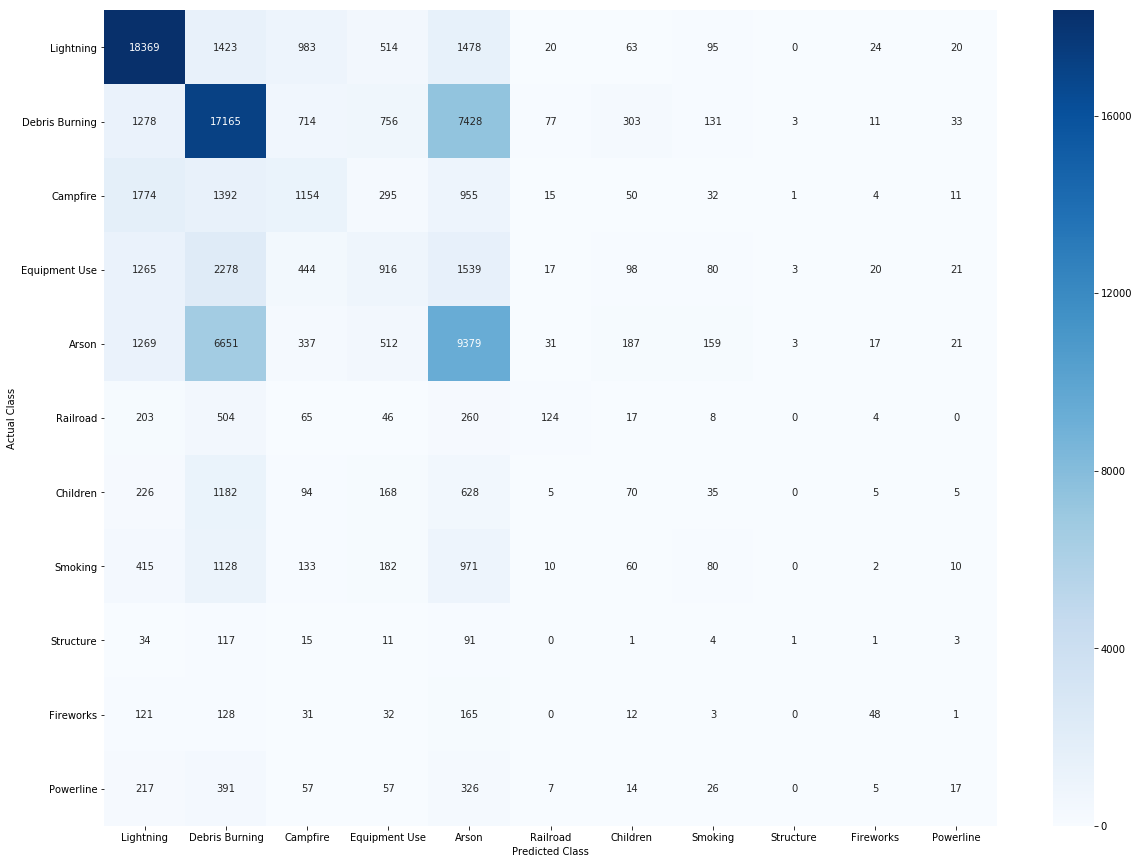

weighted_knn


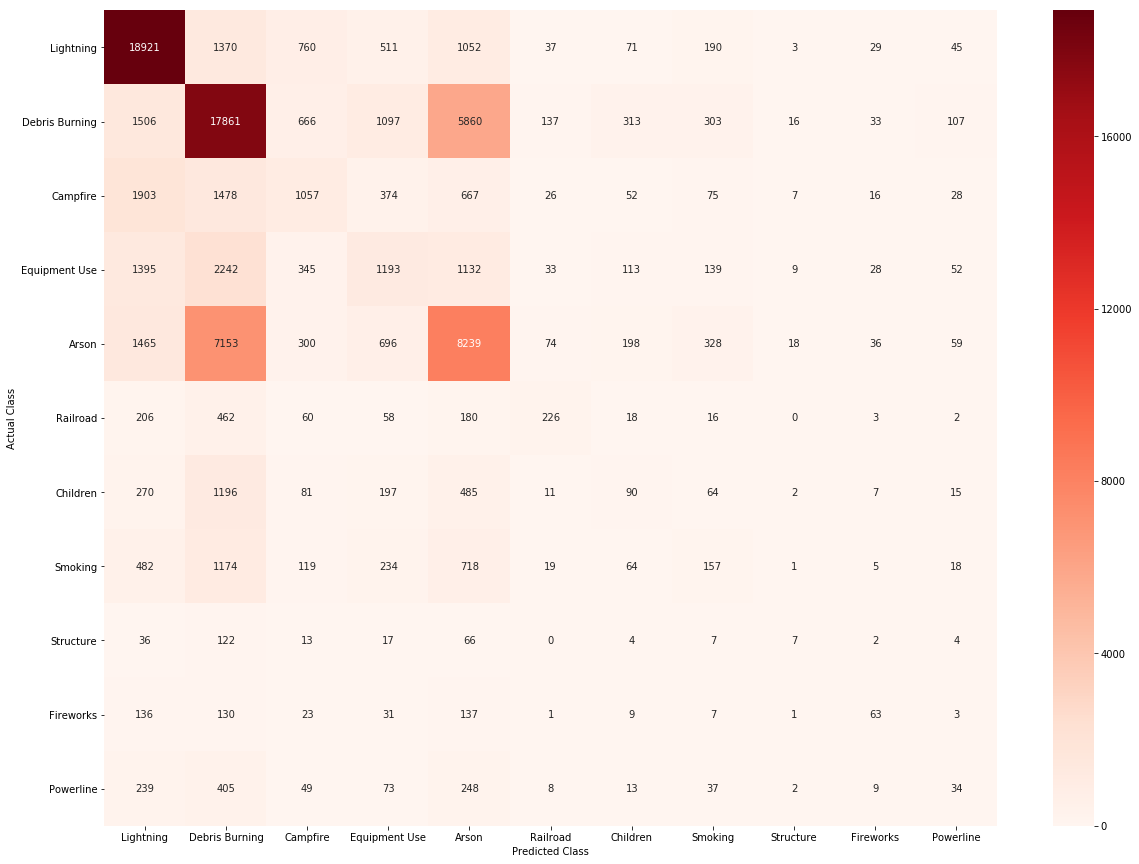

decision tree


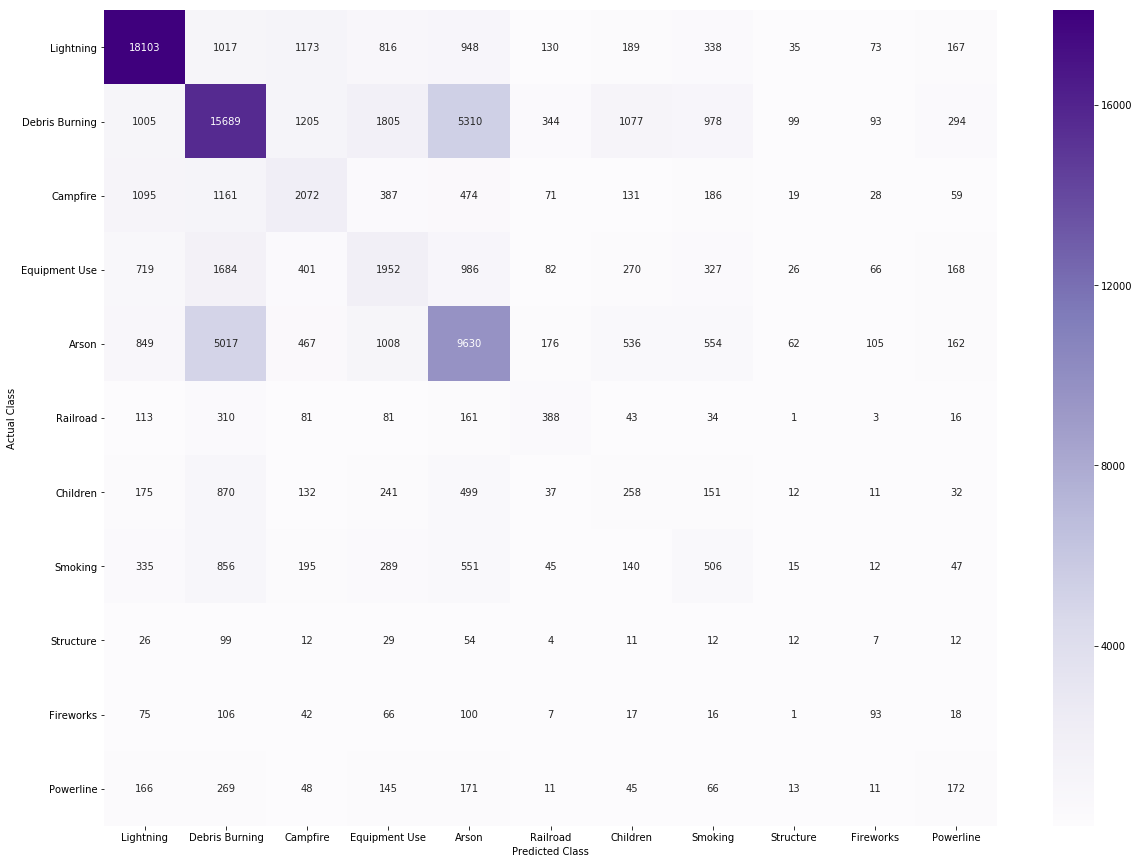

100 tree random forest


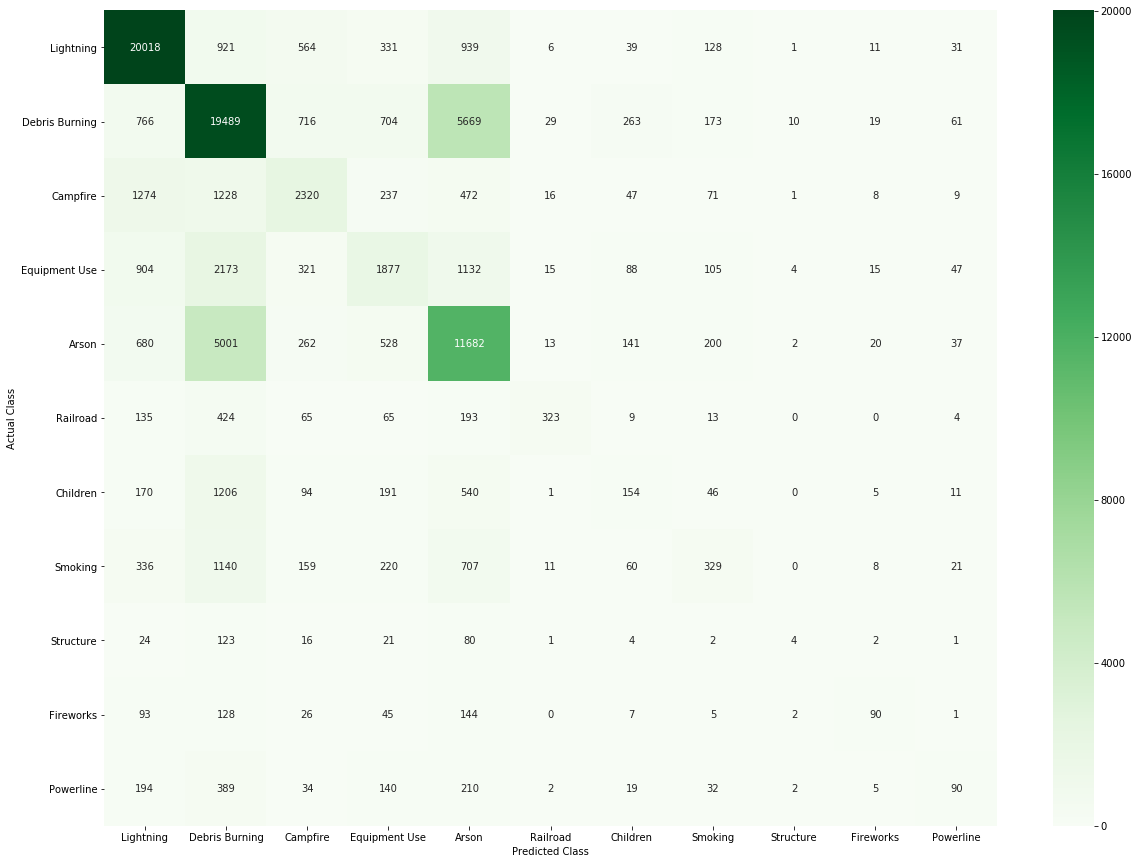

In [47]:
from collections import Counter 
from sklearn.metrics import confusion_matrix
import seaborn as sn

colors = {
    'uniform knn': "Blues", 
    'weighted_knn': "Reds",
    'decision tree': "Purples",
    '100 tree random forest':"Greens"
}

# create confusion matrixx for each prediction set
for predictions, t in zip([knn_predictions, knn_dist_predictions, dt_predictions, rf_predictions], ['uniform knn', 'weighted_knn', 'decision tree', '100 tree random forest']):
    misses = [(p, y) for p, y in zip(predictions, test_y['STAT_CAUSE_DESCR']) if p!=y]

    # create labels for confusion matrix
    labs = df5['STAT_CAUSE_DESCR'].unique()
    cf= confusion_matrix(test_y['STAT_CAUSE_DESCR'], predictions, labels=labs)

    #print title
    print(t)
    
    # create pretty matrix
    df_cm = pd.DataFrame(cf, index = [i for i in labs],
                      columns = [i for i in labs])
    plt.figure(figsize = (20,15))

    ax = sn.heatmap(df_cm, annot=True,cmap=colors[t], fmt='g')
    ax.set(xlabel='Predicted Class', ylabel='Actual Class')
    plt.show()

In [37]:
# pairs = [(p, y) for p, y in zip(knn_predictions, test_y['STAT_CAUSE_DESCR'])]
# #bottom is predicted
# #side is actual
# #tuples are predicted, actual
# from collections import Counter 
  
# occurrence_count = Counter(pairs) 

# # print(occurrence_count)
# for tup, ct in occurrence_count.items():
#     print('{}: {}'.format(tup, ct))